In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
import optuna


df = pd.read_csv("dataset.csv")  

def create_engineered_features(df):
    df['CO2_mass_flow'] = df['Exhaust CO₂ concentration (%)'] * df['Flue gas flow rate (m³/h)'] * 1.96
    df['Energy_per_CO2'] = df['Energy price (TND/kWh)'] / (df['CO2_mass_flow'] + 1e-6)
    df['Amine_loading'] = df['Amine temperature (°C)'] / (df['Amine pressure (bar)'] + 0.1)
    return df

df = create_engineered_features(df)
X = df.drop('Amine flow rate (L/min)', axis=1)
y = df['Amine flow rate (L/min)']
tscv = TimeSeriesSplit(n_splits=5)

def plant_safe_mae(y_true, y_pred):
    error = np.abs(y_true - y_pred)
    penalty = np.where((y_pred < 40) | (y_pred > 60), 3.0, 1.0)
    return np.mean(error * penalty)

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'max_features': trial.suggest_float('max_features', 0.6, 1.0)
    }

    base_model = GradientBoostingRegressor(random_state=42, **params)
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('selector', SelectFromModel(base_model, threshold='median')),
        ('model', base_model)
    ])

    scores = []
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_val)
        scores.append(plant_safe_mae(y_val, y_pred))

    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

# training
best_params = study.best_params
final_model = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(GradientBoostingRegressor(**best_params, random_state=42), threshold='median')),
    ('model', GradientBoostingRegressor(**best_params, random_state=42))
])
final_model.fit(X, y)

# Evaluation
y_pred = final_model.predict(X)
mae = mean_absolute_error(y, y_pred)
print(f"Final model MAE: {mae:.2f} L/min")
print("Best hyperparameters:", best_params)

[I 2025-04-20 02:11:53,464] A new study created in memory with name: no-name-dc6d7d3e-e7ea-4747-8868-b268ed085f31
[I 2025-04-20 02:11:56,232] Trial 0 finished with value: 5.221302726207423 and parameters: {'n_estimators': 161, 'learning_rate': 0.11105102321082663, 'max_depth': 7, 'min_samples_split': 4, 'subsample': 0.725221324114491, 'max_features': 0.9727956886361031}. Best is trial 0 with value: 5.221302726207423.
[I 2025-04-20 02:12:00,704] Trial 1 finished with value: 5.636707457233756 and parameters: {'n_estimators': 288, 'learning_rate': 0.18535935177234963, 'max_depth': 8, 'min_samples_split': 20, 'subsample': 0.8050924646463563, 'max_features': 0.6880063695343352}. Best is trial 0 with value: 5.221302726207423.
[I 2025-04-20 02:12:03,689] Trial 2 finished with value: 5.713643312397065 and parameters: {'n_estimators': 325, 'learning_rate': 0.1724909858638679, 'max_depth': 3, 'min_samples_split': 11, 'subsample': 0.753936984357714, 'max_features': 0.7921235825548021}. Best is tr

Final model MAE: 3.63 L/min
Best hyperparameters: {'n_estimators': 185, 'learning_rate': 0.010146556269181085, 'max_depth': 4, 'min_samples_split': 7, 'subsample': 0.909093165322983, 'max_features': 0.7114122050557058}


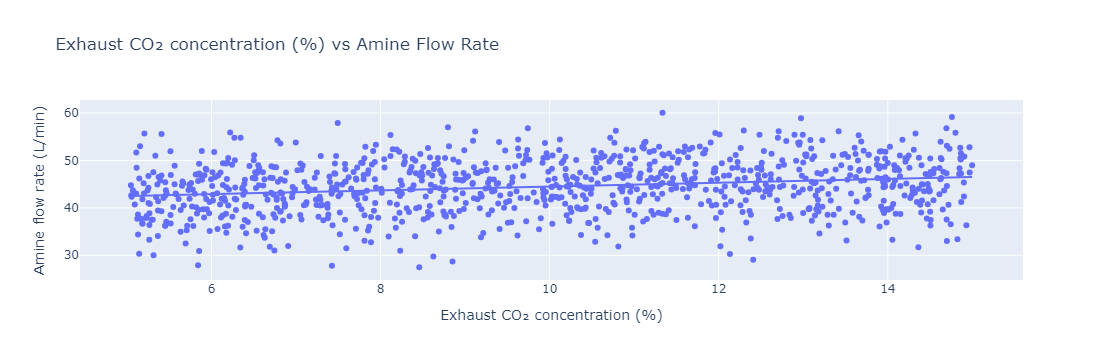

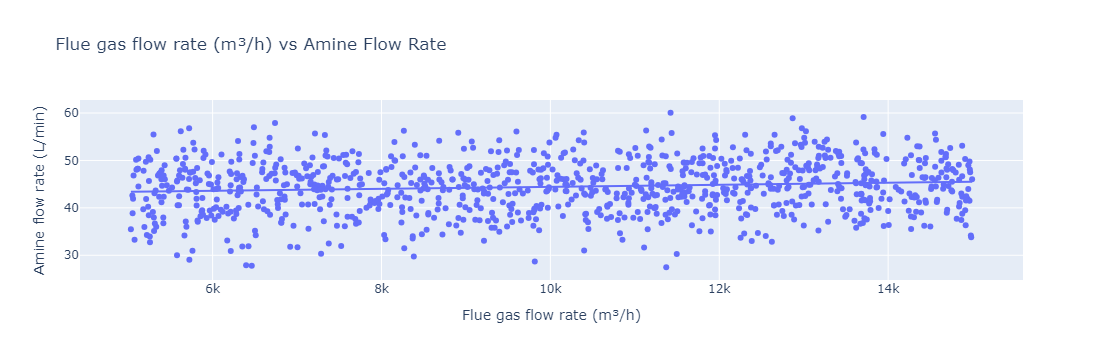

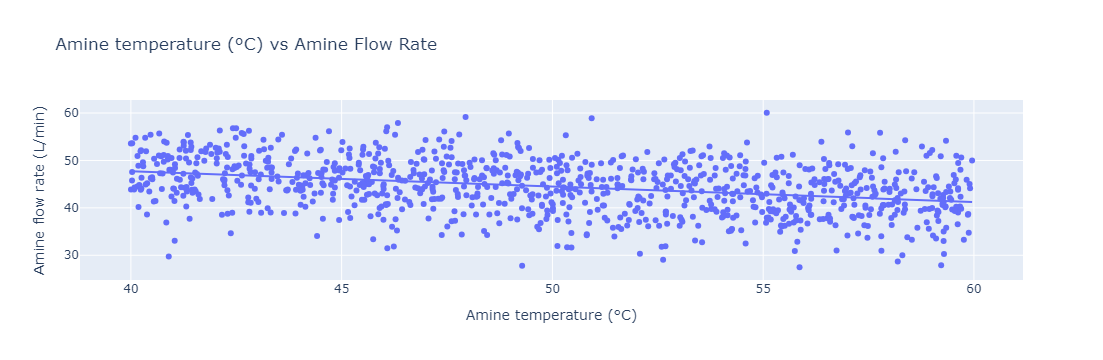

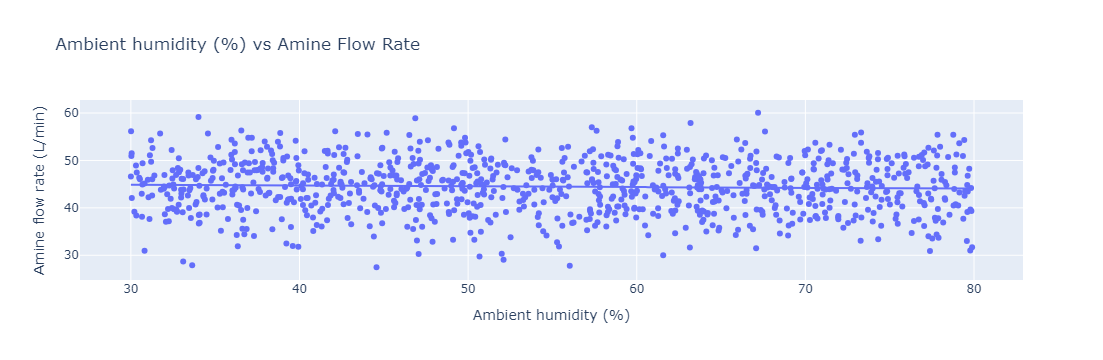

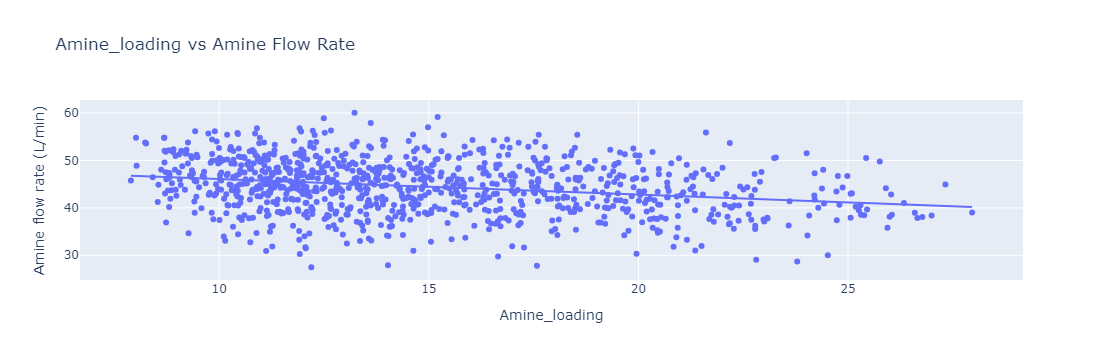

In [11]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

df = pd.read_csv("dataset.csv")  

def create_engineered_features(df):
    df['CO2_mass_flow'] = df['Exhaust CO₂ concentration (%)'] * df['Flue gas flow rate (m³/h)'] * 1.96
    df['Energy_per_CO2'] = df['Energy price (TND/kWh)'] / (df['CO2_mass_flow'] + 1e-6)
    df['Amine_loading'] = df['Amine temperature (°C)'] / (df['Amine pressure (bar)'] + 0.1)
    return df

df = create_engineered_features(df)


X = df.drop('Amine flow rate (L/min)', axis=1)
y = df['Amine flow rate (L/min)']

best_params = {
    'n_estimators': 447,
    'learning_rate': 0.011841983886274525,
    'max_depth': 8,
    'min_samples_split': 2,
    'subsample': 0.6134592081278596,
    'max_features': 0.9181749581615589
}

model = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', SelectFromModel(GradientBoostingRegressor(**best_params, random_state=42), threshold='median')),
    ('regressor', GradientBoostingRegressor(**best_params, random_state=42))
])
model.fit(X, y)


selector = model.named_steps['selector']
selected_features = X.columns[selector.get_support()]


for feature in selected_features:
    fig = px.scatter(df, x=feature, y='Amine flow rate (L/min)',
                     trendline='ols',
                     title=f"{feature} vs Amine Flow Rate",
                     labels={'x': feature, 'y': 'Amine Flow Rate (L/min)'})
    fig.show()


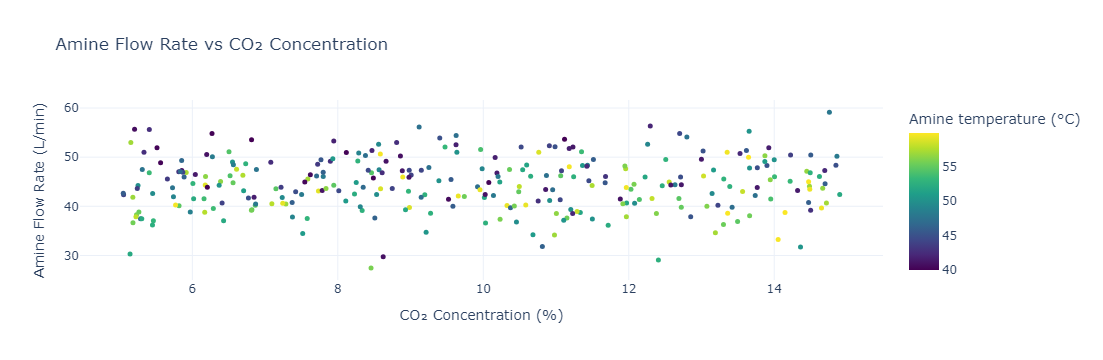

In [8]:
import pandas as pd
import plotly.express as px

df = pd.read_csv("dataset.csv")  
sample_df = df.sample(frac=0.3, random_state=42)

fig = px.scatter(
    sample_df,
    x='Exhaust CO₂ concentration (%)',
    y='Amine flow rate (L/min)',
    color='Amine temperature (°C)',  
    size='Flue gas flow rate (m³/h)',   
    hover_data=['Amine pressure (bar)', 'Energy price (TND/kWh)'],
    title='Amine Flow Rate vs CO₂ Concentration',
    labels={
        'Exhaust CO₂ concentration (%)': 'CO₂ Concentration (%)',
        'Amine flow rate (L/min)': 'Amine Flow Rate (L/min)'
    },
    color_continuous_scale='Viridis' 
)

fig.update_traces(marker=dict(size=5))
fig.update_traces(marker=dict(line=dict(width=0.005, color='DarkSlateGrey')))
fig.update_layout(template='plotly_white')
fig.show()